## Julia. Lecture 5

In [ ]:
# using Pkg
# Pkg.add("Zygote")
# Pkg.add("Flux")
# Pkg.add("Parameters")


In [17]:
using Plots
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, logitcrossentropy, throttle
using ProgressBars
using Parameters: @with_kw

### Babylonian sqrt

Этот пример очень любит давать один из авторов Julia Adam Edelman на теме автодифференцирования.
Вавилонский метод подсчета квадратного корня известен уже несколько тысяч лет, это интерактивный метод который мы можем записать как:

In [18]:
function Babylonian(x; N = 10) 
    t = (1+x)/2
    for i = 2:N
        t=(t + x/t)/2
    end    
    t
end

Babylonian (generic function with 1 method)

In [21]:
Babylonian(100)

10.0

Можем наглядно посмотреть как метод сходится к корректному значению

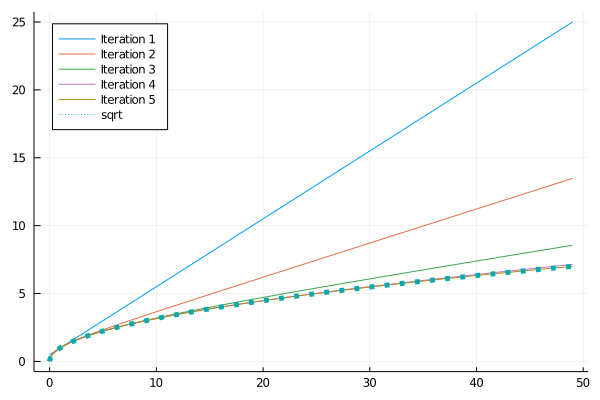

In [22]:
i = 0:0.01:49
plot([x->Babylonian(x,N=j) for j=1:5], i, label=["Iteration $j" for i=1:1,j=1:5])
plot!(i, sqrt.(i), label="sqrt", w=5, linestyle = :dot, legend=:topleft)

Теперь создадим пару функция-производная

In [23]:
struct D <: Number  # D is a function-derivative pair
    f::Tuple{Float64,Float64}
end

Правила вычисления производных
1. (x*y)' = x' + y' 
1. (x/y)' = (yx'-xy') / y^2


Для работы с нашей новой структурой нам необходимо создать методы умножения, деления и сумирования для D

In [24]:
import Base: *, +, /, convert, promote_rule
+(x::D, y::D) = D(x.f .+ y.f)
/(x::D, y::D) = D((x.f[1]/y.f[1], (y.f[1]*x.f[2] - x.f[1]*y.f[2])/y.f[1]^2))
*(x::D, y::D) = D(x.f[1]* y.f[1], x.f[1]*y.f[2]+x.f[2]*y.f[1])
convert(::Type{D}, x::Real) = D((x,zero(x)))
promote_rule(::Type{D}, ::Type{<:Number}) = D

promote_rule (generic function with 161 methods)

In [30]:
x = 2
Babylonian(D((x,1))), (√x,.5/√x)

(D((1.414213562373095, 0.35355339059327373)), (1.4142135623730951, 0.35355339059327373))

А теперь сделаем тоже самое с помощью библиотеки Zygote

In [31]:
using Zygote
f(x) = sqrt(x)
f(x), f'(x)

(1.4142135623730951, 0.35355339059327373)

### Flux

Определим гиперпараметры

In [33]:
@with_kw mutable struct Args
    lr::Float64 = 3e-3
    epochs::Int = 5
    batch_size = 128
end
args = Args()

Args
  lr: Float64 0.003
  epochs: Int64 5
  batch_size: Int64 128


Загрузим данные и создадим дата лоадер

In [32]:
train_labels = MNIST.labels();
train_imgs = MNIST.images();

test_labels = MNIST.labels(:test);
test_imgs = MNIST.images(:test);

In [37]:
size(train_imgs)

(60000,)

In [41]:
function prepare_dataloader(imgs, labels; batchsize=128, shuffle=false)
    l = length(imgs)
    img_tensor = Array{Float32}(undef, size(imgs[1])..., 1, l);
    for i in 1:l
       img_tensor[:, :, :, i] =  imgs[i];
    end
    labels_tensor = onehotbatch(labels, 0:9);
    return Flux.Data.DataLoader((img_tensor, labels_tensor), batchsize=batchsize, shuffle=shuffle);
end

prepare_dataloader (generic function with 1 method)

In [42]:
train_dataloader = prepare_dataloader(train_imgs, train_labels, batchsize = 128, shuffle=true);
test_dataloader = prepare_dataloader(test_imgs, test_labels, batchsize = 128, shuffle=false);

Напишем функцию Lenet5

In [47]:
function LeNet5(nclasses=10) 
    
    return Chain(
            Conv((5, 5), 1=>6, relu),
            MaxPool((2, 2)),
            Conv((5, 5), 6=>16, relu),
            MaxPool((2, 2)),
            flatten,
            Dense(4*4*16, 120, relu), 
            Dense(120, 84, relu), 
            Dense(84, nclasses)
            
          )
end


LeNet5 (generic function with 2 methods)

Создадим две функции для лосс и для точности модели

In [48]:
function accuracy(data_loader, model)
    acc = 0
    for i in data_loader
        acc += (sum(onecold(model(i[1])) .== onecold(i[2]))*1)/ size(i[1], 4)
    end
    acc/length(data_loader)
end

accuracy (generic function with 1 method)

In [49]:
function loss(x,y)
    y_hat = model(x);
    return logitcrossentropy(y_hat, y)    
end

loss (generic function with 1 method)

In [52]:
opt = ADAM(args.lr)
model = LeNet5()

Chain(Conv((5, 5), 1=>6, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((5, 5), 6=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), flatten, Dense(256, 120, relu), Dense(120, 84, relu), Dense(84, 10))

Тренировка модели:

In [53]:
for epoch_idx in ProgressBar(1:args.epochs)
        # Train for a single epoch
        cb_model() =  @show accuracy(test_dataloader, model)
        Flux.train!(loss, params(model), train_dataloader, opt,
            cb = throttle(cb_model, 10)) 
        # Calculate accuracy:
        acc_train = accuracy(train_dataloader, model)
        acc_test = accuracy(test_dataloader, model)
        println("Train accuracy: $(acc_train), Test: $(acc_test)")
end

0.0%┣                                            ┫ 0/5 [00:00<00:00, -20.0 it/s]accuracy(test_dataloader, model) = 0.1261867088607595
accuracy(test_dataloader, model) = 0.9683544303797469
Train accuracy: 0.9797219260838663, Test: 0.9792325949367089
20.0%┣████████▋                                  ┫ 1/5 [00:48<Inf:Inf, 0.0 it/s]accuracy(test_dataloader, model) = 0.978243670886076
accuracy(test_dataloader, model) = 0.9831882911392406
Train accuracy: 0.9849524697938876, Test: 0.9834849683544303
40.0%┣██████████████████                           ┫ 2/5 [01:12<03:35, 0.0 it/s]accuracy(test_dataloader, model) = 0.9833860759493671
accuracy(test_dataloader, model) = 0.984375
Train accuracy: 0.9871512970859986, Test: 0.9865506329113924
60.0%┣███████████████████████████                  ┫ 3/5 [01:38<01:38, 0.0 it/s]accuracy(test_dataloader, model) = 0.9865506329113924
accuracy(test_dataloader, model) = 0.9832871835443038
Train accuracy: 0.9914323471926083, Test: 0.987440664556962
80.0%┣██████████

Посмотрим на предсказания на тесте

In [57]:
test_batch = collect(test_dataloader)[1];
softmax(model(test_batch[1]))

10×128 Array{Float32,2}:
 3.77415f-11  9.50342f-8   6.22655f-6  …  0.99859      6.12312f-10
 8.13155f-10  8.28806f-9   0.999911       3.83509f-10  1.02432f-14
 4.5576f-9    1.0          5.55155f-6     0.00139977   1.77176f-14
 1.38309f-7   1.50588f-12  1.91516f-8     5.88071f-8   1.51854f-8
 3.4593f-9    8.506f-10    1.09408f-5     4.10275f-7   3.27829f-13
 9.03433f-9   5.11855f-12  5.12856f-6  …  4.33657f-7   1.0
 1.48948f-13  7.98524f-11  1.40195f-5     2.12143f-8   1.47813f-9
 1.0          4.08263f-10  1.43222f-5     1.16129f-7   6.59286f-12
 4.76196f-9   4.92685f-9   3.12643f-5     3.62826f-6   3.32521f-9
 1.51198f-7   6.4856f-13   1.22014f-6     5.24256f-6   2.33907f-8

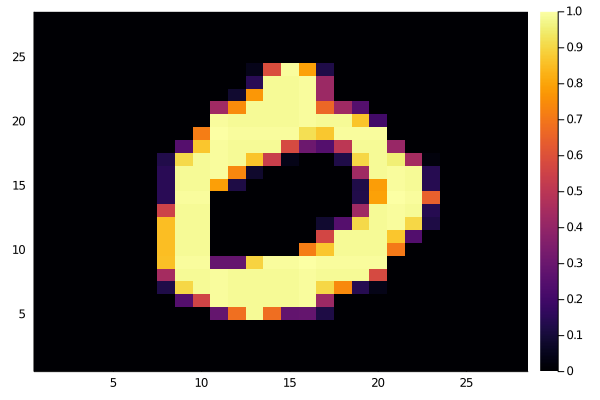

In [61]:
n = 4
heatmap(test_batch[1][:,:,1,n][end:-1:1,:],rationration = 1)